In [1]:
# Install required packages (run once)
!pip install networkx matplotlib pandas tabulate memory_profiler --quiet

%load_ext memory_profiler

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
import heapq, time, random
from collections import defaultdict


In [2]:
def measure_time_and_memory(func, *args, **kwargs):
    """Measure execution time and approximate memory usage (MiB)."""
    from memory_profiler import memory_usage
    start = time.time()
    mem_usage = memory_usage((func, args, kwargs), interval=0.01, timeout=None)
    result = func(*args, **kwargs)
    end = time.time()
    elapsed = end - start
    mem_used = max(mem_usage) - min(mem_usage)
    return result, elapsed, mem_used

def print_table(title, data_dict):
    """Pretty-print a dictionary as a table."""
    df = pd.DataFrame(list(data_dict.items()), columns=['Node', 'Value'])
    print(f"\n📊 {title}")
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))



📊 Friend Suggestions for A
+--------+---------+
| Node   |   Value |
|--------+---------|
| D      |       1 |
| E      |       1 |
| G      |       1 |
+--------+---------+
⏱ Time: 0.12740s | 💾 Memory: 0.00 MiB


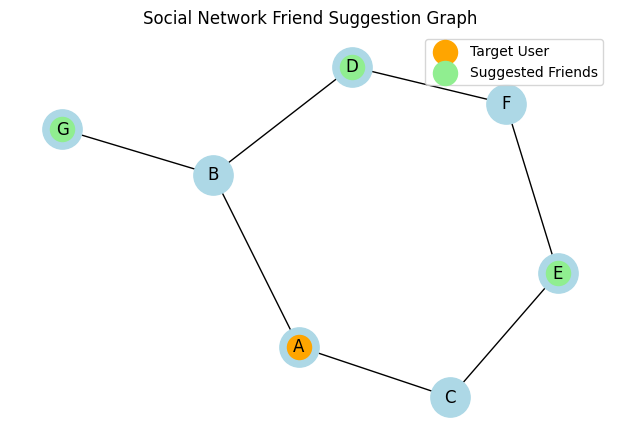

In [3]:
class SocialGraph:
    def __init__(self):
        self.graph = defaultdict(set)
    def add_friendship(self, a, b):
        self.graph[a].add(b)
        self.graph[b].add(a)

def suggest_friends(graph, user):
    """Find friends of friends not already connected."""
    suggestions = defaultdict(int)
    direct_friends = graph.graph[user]
    for friend in direct_friends:
        for fof in graph.graph[friend]:
            if fof != user and fof not in direct_friends:
                suggestions[fof] += 1
    return dict(sorted(suggestions.items(), key=lambda x: (-x[1], x[0])))

# --- Sample Graph ---
sg = SocialGraph()
edges = [('A','B'),('A','C'),('B','D'),('C','E'),('D','F'),('E','F'),('B','G')]
for u,v in edges:
    sg.add_friendship(u,v)

# --- Compute Suggestions ---
(user, (res, t, mem)) = ('A', measure_time_and_memory(suggest_friends, sg, 'A'))
print_table(f"Friend Suggestions for {user}", res)
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")

# --- Visualize ---
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=2)
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800)
nx.draw_networkx_nodes(G, pos, nodelist=[user], node_color='orange', label='Target User')
nx.draw_networkx_nodes(G, pos, nodelist=res.keys(), node_color='lightgreen', label='Suggested Friends')
plt.legend()
plt.title("Social Network Friend Suggestion Graph")
plt.show()



📊 Shortest Distances from S
+--------+---------+
| Node   |   Value |
|--------+---------|
| S      |       0 |
| A      |       0 |
| B      |      -3 |
| C      |      -8 |
| D      |      -5 |
+--------+---------+
⏱ Time: 0.07319s | 💾 Memory: 0.00 MiB
⚠️ Negative Cycle Detected at: ['C']


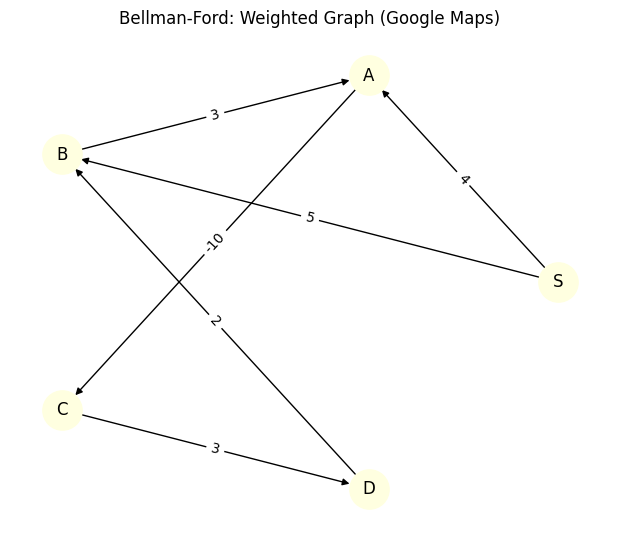

In [4]:
def bellman_ford(vertices, edges, src):
    dist = {v: float('inf') for v in vertices}
    dist[src] = 0
    pred = {v: None for v in vertices}

    for _ in range(len(vertices)-1):
        for u, v, w in edges:
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u

    # detect negative cycles
    neg_cycle = []
    for u, v, w in edges:
        if dist[u] + w < dist[v]:
            neg_cycle.append(v)
    return dist, pred, neg_cycle

# --- Graph Input ---
vertices = ['S','A','B','C','D']
edges = [('S','A',4), ('S','B',5), ('A','C',-10), ('B','A',3), ('C','D',3), ('D','B',2)]

(result, t, mem) = measure_time_and_memory(bellman_ford, vertices, edges, 'S')
dist, pred, neg = result
print_table("Shortest Distances from S", dist)
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")
if neg:
    print("⚠️ Negative Cycle Detected at:", neg)

# --- Visualization ---
G = nx.DiGraph()
G.add_weighted_edges_from(edges)
pos = nx.circular_layout(G)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color='lightyellow', node_size=800, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.title("Bellman-Ford: Weighted Graph (Google Maps)")
plt.show()



📊 Shortest Travel Times from A
+--------+---------+
| Node   |   Value |
|--------+---------|
| A      |       0 |
| B      |       4 |
| C      |       2 |
| D      |       5 |
+--------+---------+
⏱ Time: 0.07458s | 💾 Memory: 0.00 MiB


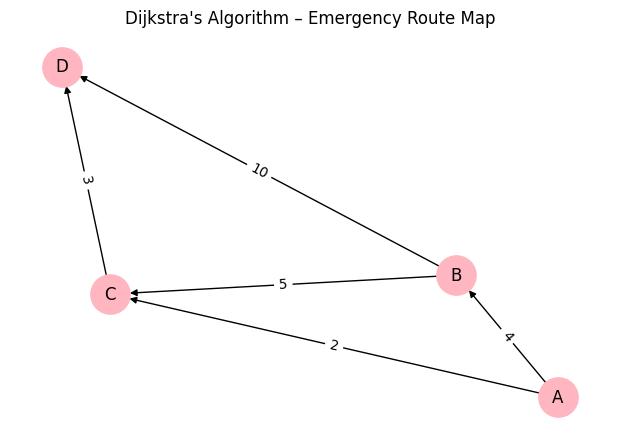

In [5]:
def dijkstra(adj, src):
    dist = {v: float('inf') for v in adj}
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v, w in adj[u]:
            if d + w < dist[v]:
                dist[v] = d + w
                heapq.heappush(pq, (dist[v], v))
    return dist

# --- City Map ---
adj = {
    'A': [('B',4),('C',2)],
    'B': [('C',5),('D',10)],
    'C': [('D',3)],
    'D': []
}

(result, t, mem) = measure_time_and_memory(dijkstra, adj, 'A')
dist = result
print_table("Shortest Travel Times from A", dist)
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")

# --- Visualization ---
G = nx.DiGraph()
for u in adj:
    for v,w in adj[u]:
        G.add_edge(u,v,weight=w)
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color='lightpink', node_size=800, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.title("Dijkstra's Algorithm – Emergency Route Map")
plt.show()


Total MST Cost = 7
Edges in MST :
  A – B  (weight 2)
  B – C  (weight 1)
  B – D  (weight 4)
⏱ Time: 0.07296s | 💾 Memory: 0.00 MiB


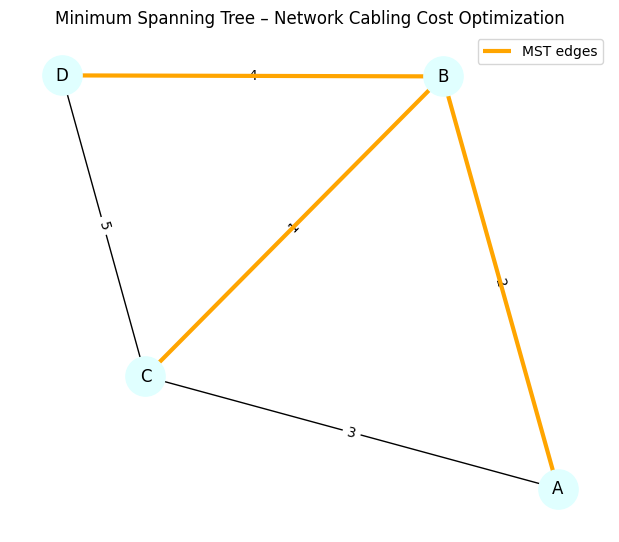

In [7]:
def prim_mst(adj, start):
    visited = {start}
    edges = [(w, start, v) for v, w in adj[start]]
    heapq.heapify(edges)
    mst_edges, total = [], 0
    while edges:
        w, u, v = heapq.heappop(edges)
        if v not in visited:
            visited.add(v)
            total += w
            mst_edges.append((u, v, w))
            for nxt, wt in adj[v]:
                if nxt not in visited:
                    heapq.heappush(edges, (wt, v, nxt))
    return total, mst_edges

# --- Network Graph ---
adj = {
    'A':[('B',2),('C',3)],
    'B':[('A',2),('C',1),('D',4)],
    'C':[('A',3),('B',1),('D',5)],
    'D':[('B',4),('C',5)]
}

(result, t, mem) = measure_time_and_memory(prim_mst, adj, 'A')
cost, edges = result
print(f"Total MST Cost = {cost}")
print("Edges in MST :")
for e in edges:
    print(f"  {e[0]} – {e[1]}  (weight {e[2]})")
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")

# --- Visualization ---
G = nx.Graph()
for u in adj:
    for v, w in adj[u]:
        G.add_edge(u, v, weight=w)
pos = nx.spring_layout(G, seed=10)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color='lightcyan', node_size=800)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'))
nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in edges], width=3, edge_color='orange', label='MST edges')
plt.legend()
plt.title("Minimum Spanning Tree – Network Cabling Cost Optimization")
plt.show()

In [9]:
summary = {
    'Social Network Suggestion (BFS)': 'O(V+E) → Mutual friend recommendations',
    'Route Finding (Bellman-Ford)': 'O(VE) → Works with negative edges',
    'Emergency Path (Dijkstra)': 'O(E log V) → Fast shortest path positive weights',
    'Cable Installation (MST)': 'O(E log V) → Minimum cost network'
}
print_table("Final Project Summary", summary)


📊 Final Project Summary
+---------------------------------+--------------------------------------------------+
| Node                            | Value                                            |
|---------------------------------+--------------------------------------------------|
| Social Network Suggestion (BFS) | O(V+E) → Mutual friend recommendations           |
| Route Finding (Bellman-Ford)    | O(VE) → Works with negative edges                |
| Emergency Path (Dijkstra)       | O(E log V) → Fast shortest path positive weights |
| Cable Installation (MST)        | O(E log V) → Minimum cost network                |
+---------------------------------+--------------------------------------------------+
